In [ ]:

!pip install gensim==3.8.3

  Using cached gensim-3.8.3.tar.gz (23.4 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
  Running setup.py clean for gensim
Failed to build gensim
ERROR: Could not build wheels for gensim, which is required to install pyproject.toml-based projects


In [ ]:

!pip install keras --upgrade
!pip install pandas --upgrade

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8


In [ ]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 20
W2V_MIN_COUNT = 10

In [ ]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 5
BATCH_SIZE = 512



In [ ]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)



In [ ]:
# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
print("Dataset size:", len(df))

Dataset size: 200000


In [ ]:
df = df[700000:900000]

In [ ]:
neg_df = df[0:100000]
pos_df = df[100001:200000]

In [ ]:
df.head(10)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 1.06 s, sys: 1.46 ms, total: 1.06 s
Wall time: 1.09 s


Text(0.5, 1.0, 'Dataset labels distribuition')

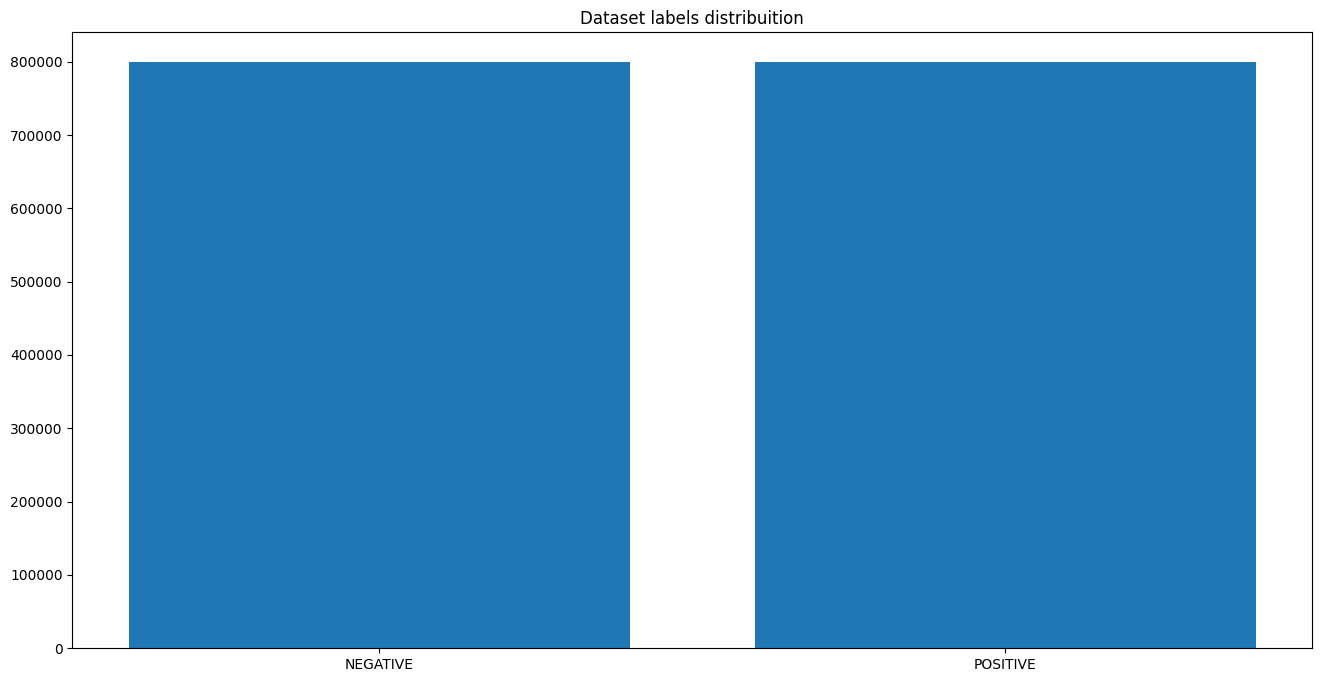

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

NLP pre-processing

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
tweet = input('Enter a tweet : ')
Processed_tweet = preprocess(tweet)
print("Processed tweet : " +Processed_tweet)

Enter a tweet : #Rohit is the leading runscorer of #CWC
Processed tweet : rohit leading runscorer cwc


In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 5s, sys: 222 ms, total: 1min 5s
Wall time: 1min 6s


In [ ]:
df.head(2)

,target,ids,date,flag,user,text
750000,NEGATIVE,2285370474,Mon Jun 22 15:02:48 PDT 2009,NO_QUERY,idmoore,small slip tryfan weeks back felt side pull di...
750001,NEGATIVE,2285370823,Mon Jun 22 15:02:49 PDT 2009,NO_QUERY,xbeautifulmessx,post han want great still working tld though g...


In [ ]:
import re
import nltk
from nltk.corpus import stopwords #To Remove the StopWords like "the","in" ect
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [ ]:
def unigram(data):
    text = " ".join(data)
    CleanedText = re.sub(r'[^a-zA-Z]'," ",text)
    CleanedText = " ".join([WordNetLemmatizer().lemmatize(word) for word in nltk.word_tokenize(CleanedText) if word not in stopwords.words("english") and len(word) > 3])
    return CleanedText

In [ ]:
NegCleanedText = unigram(neg_df['text'])
PosCleanedText = unigram(pos_df['text'])

Positive Tweets Word Cloud

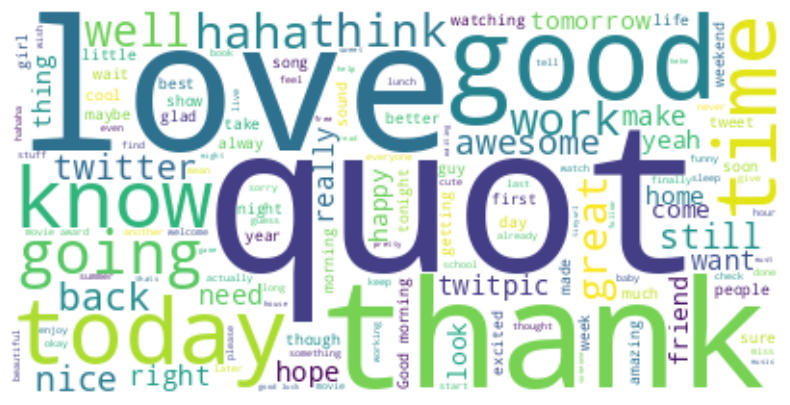

In [ ]:
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt
wordcloud = WordCloud(random_state=21, background_color='white').generate(PosCleanedText)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

Negative Tweets Word Cloud

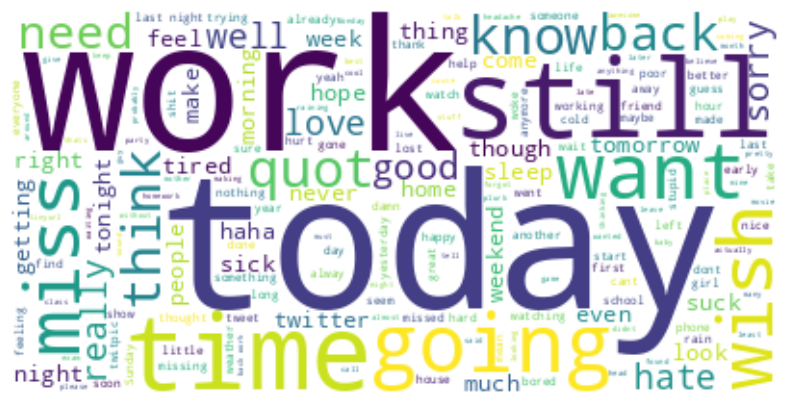

In [ ]:
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt
wordcloud = WordCloud(random_state=21, background_color='white').generate(NegCleanedText)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

Split into training and testing

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


Feature Selection

Word2vec

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 4.19 s, sys: 463 ms, total: 4.65 s
Wall time: 4.68 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=300,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = list(w2v_model.wv.index_to_key)

vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 13min 8s, sys: 2.92 s, total: 13min 11s
Wall time: 8min 42s


(164453298, 184544080)

In [ ]:
w2v_model.wv.most_similar("happy")

[('celebrations', 0.4519229829311371),
 ('celebrated', 0.4469011127948761),
 ('celebrating', 0.42427971959114075),
 ('happiest', 0.41559502482414246),
 ('happpy', 0.40607136487960815),
 ('happier', 0.3896174132823944),
 ('40th', 0.3881651759147644),
 ('blessed', 0.3851771950721741),
 ('happppy', 0.3832121193408966),
 ('proud', 0.3811141550540924)]

In [ ]:
w2v_model.wv.most_similar("sad")

[('depressed', 0.5765566229820251),
 ('upset', 0.5510947704315186),
 ('bummed', 0.5275001525878906),
 ('sadder', 0.49141108989715576),
 ('sadd', 0.4632839858531952),
 ('bittersweet', 0.4496845602989197),
 ('devastated', 0.4422130286693573),
 ('unhappy', 0.4248136281967163),
 ('cry', 0.4140697121620178),
 ('upsetting', 0.41361990571022034)]

Tokenizer

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 23.2 s, sys: 55.3 ms, total: 23.2 s
Wall time: 23.5 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 30 s, sys: 2.12 s, total: 32.1 s
Wall time: 35.9 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          87125700  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 87286201 (332.97 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87125700 (332.36 MB)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/5
125/125 [==============================] - 800s 6s/step - loss: 0.5489 - accuracy: 0.7153 - val_loss: 0.5139 - val_accuracy: 0.7473 - lr: 0.0010
Epoch 2/5
125/125 [==============================] - 810s 6s/step - loss: 0.5180 - accuracy: 0.7383 - val_loss: 0.5015 - val_accuracy: 0.7548 - lr: 0.0010
Epoch 3/5
125/125 [==============================] - 817s 7s/step - loss: 0.5068 - accuracy: 0.7478 - val_loss: 0.4952 - val_accuracy: 0.7559 - lr: 0.0010
Epoch 4/5
125/125 [==============================] - 819s 7s/step - loss: 0.5342 - accuracy: 0.7315 - val_loss: 0.5123 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 5/5
125/125 [==============================] - 820s 7s/step - loss: 0.5092 - accuracy: 0.7435 - val_loss: 0.4974 - val_accuracy: 0.7566 - lr: 0.0010
CPU times: user 1h 37min 25s, sys: 6min 39s, total: 1h 44min 4s
Wall time: 1h 8min 29s


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40/40 [==============================] - 102s 3s/step - loss: 0.4886 - accuracy: 0.7606

ACCURACY: 0.7606499791145325
LOSS: 0.4885503947734833
CPU times: user 1min 19s, sys: 11.4 s, total: 1min 31s
Wall time: 1min 41s


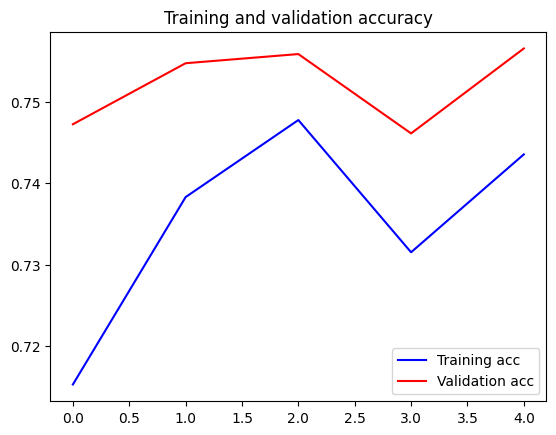

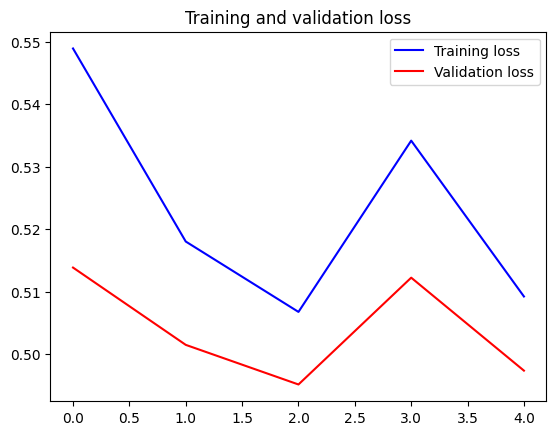

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

Predictions

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

Twitter Sentiment Analysis Test Cases


In [ ]:
predict("My day went very well")

1/1 [==============================] - 0s 112ms/step


{'label': 'NEUTRAL',
 'score': 0.5217142105102539,
 'elapsed_time': 0.1774759292602539}

In [ ]:
predict("I had  bad day")

1/1 [==============================] - 0s 120ms/step


{'label': 'NEUTRAL',
 'score': 0.5492539405822754,
 'elapsed_time': 0.19716715812683105}

In [ ]:
predict("I am a neutral spectator")

1/1 [==============================] - 0s 124ms/step


{'label': 'NEUTRAL',
 'score': 0.5970157980918884,
 'elapsed_time': 0.22063708305358887}

In [ ]:
predict("love you")

1/1 [==============================] - 0s 117ms/step


{'label': 'POSITIVE',
 'score': 0.8946244120597839,
 'elapsed_time': 0.19500732421875}

In [ ]:
len(x_test)

20000

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=500)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 59s 1s/step
CPU times: user 1min 18s, sys: 10.9 s, total: 1min 29s
Wall time: 1min 22s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


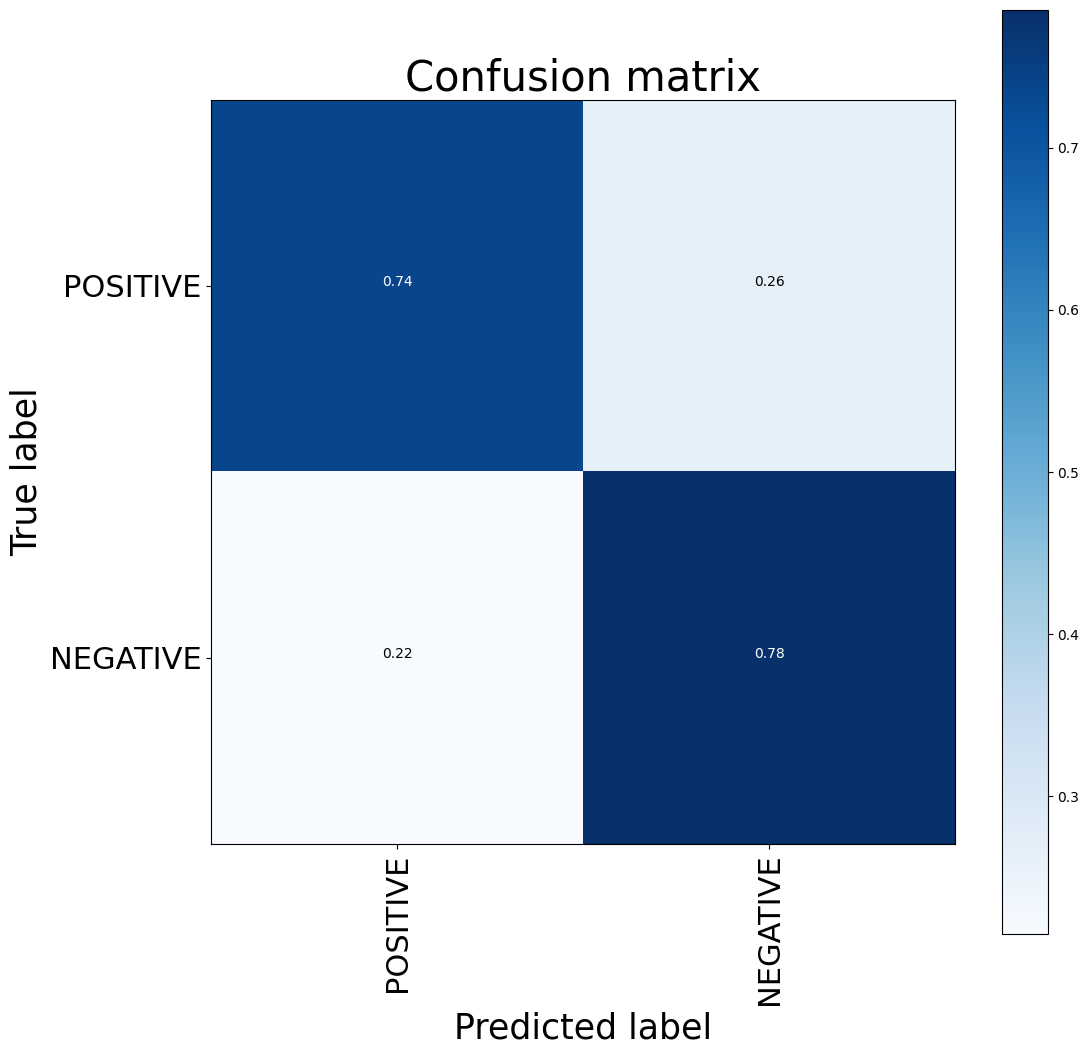

CPU times: user 598 ms, sys: 154 ms, total: 752 ms
Wall time: 852 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.74      0.76     10035
    POSITIVE       0.75      0.78      0.77      9965

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.76065

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
